In [ ]:
!pip install quantecon

In [ ]:
# Importa as bibliotecas
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import quantecon as qe
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time

start = time.time()

pd.set_option('display.max_columns', 200)

# Lê o arquivo da Penn World Table localizada no google drive
dados = pd.read_excel('https://raw.githubusercontent.com/kaiquerdg/Modelo-Neoclassico-de-Crescimento-Economico-NCGM-/main/pwt1001.xlsx')

In [ ]:
# Trata os dados
dados_brasil = dados.loc[dados['countrycode'] == "BRA"]
dados_brasil = dados_brasil.set_index("year")
dados_brasil = dados_brasil.dropna(subset = ["rtfpna"])

In [ ]:
# Função que calcula o ciclo e a tendência usando o Filtro HP
ciclo, tendencia = sm.tsa.filters.hpfilter(dados_brasil["rtfpna"], 100)

# Adiciona as colunas de ciclo e tendência na tabela
dados_brasil["ciclo"] = ciclo
dados_brasil["tendencia"] = tendencia

In [ ]:
# Cria as listas
produtividade_t1 = list(ciclo)
produtividade_t0 = list(ciclo)
produtividade_t1.pop()
produtividade_t0.pop(0)

# Aplicando a transformação log-log
x = sm.add_constant(produtividade_t0)
y = produtividade_t1

# Criação do objeto de regressão linear
modelo = sm.OLS(y, x)

# Treinamento do modelo
regressao = modelo.fit()
descricao = regressao.summary()

# Guarda rho e sigma
sigma = regressao.bse[1]
rho = regressao.params[1]
mu = regressao.params[0]
print(descricao)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     23.05
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           1.01e-05
Time:                        15:22:15   Log-Likelihood:                 135.65
No. Observations:                  65   AIC:                            -267.3
Df Residuals:                      63   BIC:                            -263.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.053      0.9

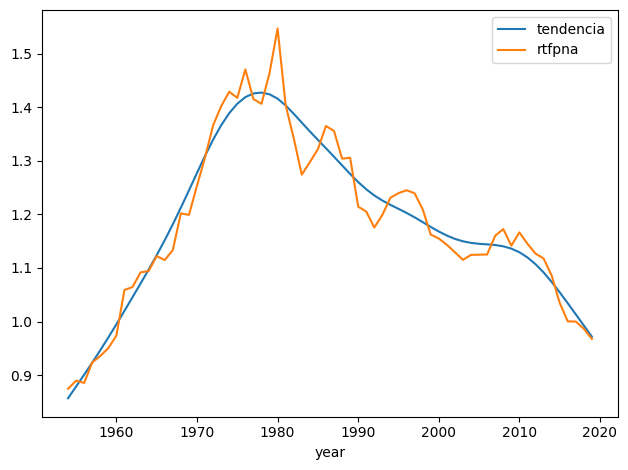

In [ ]:
# Plota a curva de tendência e a produtividade real do período
dados_brasil[["tendencia", "rtfpna"]].plot()
plt.tight_layout()

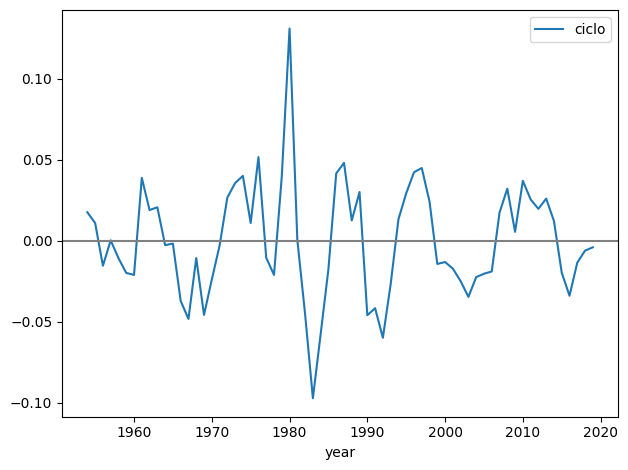

In [ ]:
# Plota o ciclo, que é a diferença entre a produtividade real e a tendência
dados_brasil[["ciclo"]].plot()
plt.axhline(y=0, color="grey")
plt.tight_layout()

In [ ]:
tauchen = qe.tauchen(5, rho, sigma, mu)
prob_estados = tauchen.state_values
matriz_markov = tauchen.P
np.set_printoptions(precision = 7, suppress = True)

In [ ]:
prob_estados

array([-0.3785141, -0.1890471,  0.00042  ,  0.189887 ,  0.3793541])

In [ ]:
matriz_markov

array([[0.2083523, 0.6185766, 0.1695659, 0.0035009, 0.0000043],
       [0.0425562, 0.4704019, 0.4500519, 0.0367907, 0.0001993],
       [0.004252 , 0.1859573, 0.6195813, 0.1859573, 0.004252 ],
       [0.0001993, 0.0367907, 0.4500519, 0.4704019, 0.0425562],
       [0.0000043, 0.0035009, 0.1695659, 0.6185766, 0.2083523]])

In [ ]:
# Cria as constantes da economia brasileira de acordo com o artigo de Rodrigo M. Pereira
a = 0.448 # Alpha: expoente da função de produção
b = 0.952 # Beta: fator de desconto intertemporal
d = 0.103 # Delta: depreciação do capital
s = 0.8163 # Sigma: aversão relativa ao risco do consumidor
f = 0.0001 # Phi: elasticidade da oferta de trabalho

rd.seed(0) # Faz com que o resultado do sorteio seja sempre o mesmo

# Cria os valores que o capital e o trabalho podem assumir
K = list(np.linspace(3, 10, 50)) # 1000
nt = list(np.linspace(0.1, 1, 10)) # 100

# Cria a variável estocástica
zt = np.exp(prob_estados)

# Cria uma função para calcular a esperança
def E(v, v2, matriz_markov):
    esp = 0
    for i in range(len(v)):
       esp = esp + v[i] * matriz_markov[v2][i]
    return esp

# Cria a função de produção
producao = lambda k, z, n: z * (k ** a) * (n ** (1 - a))

# Cria a função V com função de utilidade CRRA
v = lambda k, k_t1, z, v_zero, h, matriz_markov, n: (( producao(k, z, n) + (1 - d) * k - k_t1) ** (1 - s)) / (1 - s) - ((n) ** (1 + f)) / (1 + f) + b * (E(v_zero, h, matriz_markov))

# Cria uma matriz de zeros
v_zero = np.zeros((len(K), len(matriz_markov)))

In [ ]:
def indice_jk(m):
    j_maximiza = 0
    k_maximiza = 0
    maior_valor = m[0][0]
    for linha_j in range((len(m))):
        for coluna_k in range(len(m[0])):
            if maior_valor < m[linha_j][coluna_k]:
               maior_valor = m[linha_j][coluna_k]
               j_maximiza = linha_j
               k_maximiza = coluna_k
    return [j_maximiza, k_maximiza]

In [ ]:
# A função "while" com três "for" preenche o tensor V
def maximizacao(K, s, zt, matriz_markov, a, b, d, v_zero, nt):

    # Faz essas listas serem globais
    global tensor, tensor_argmax, tensor_nt

    # # Cria as listas que serão usadas
    maximizador = np.zeros((len(K), len(nt)))
    v_atual = v_zero
    vz_proxima = []
    vz_posicao = []
    vz_proxima_aux = []
    vz_posicao_aux = []
    tensor = [v_atual]
    tensor_argmax = []
    tensor_nt = []
    nt_otimo_aux = []
    nt_otimo = []

    # Cria os critérios de parada
    tol = 0.0001
    cont = 0
    dist = 10

    # Cria o while que itera as funções
    while cont < 200 and dist > tol:
        cont = cont + 1

        # Fixa o zt
        for h in range(len(zt)): # h = posição do zt
            z = zt[h]

            # Fixa o K
            for i in range(len(K)): # i = posição do k_t

                # Computa a função para cada k_{t+1}
                for j in range(len(K)): # j = posição do k_{t+1}

                    for k in range(len(nt)):
                        n = nt[k]

                        if producao(K[j], z, n) + (1 - d) * K[i] - K[j] > 0: # O consumo não pode ser negativo
                           maximizador[j][k] = v(K[i], K[j], z, v_atual[j], h, matriz_markov, n) # Anexa na matriz maximizador
                           if np.isnan(maximizador[j][k]) == True:
                              maximizador[j][k] = -99999999
                        else:
                            maximizador[j][k] = -99999999

                vz_posicao_aux.append(indice_jk(maximizador)[0]) # Anexa o índice do argumento que maximiza k_{t+1}
                nt_otimo_aux.append(indice_jk(maximizador)[1]) # Anexa o índice do argumento que maximiza n_t
                vz_proxima_aux.append(np.max(maximizador)) # Anexa o maior valor de cada coluna

            # Anexa as listas auxiliares
            nt_otimo.append(nt_otimo_aux)
            vz_proxima.append(vz_proxima_aux)
            vz_posicao.append(vz_posicao_aux)

            # Zera as listas
            vz_proxima_aux = []
            vz_posicao_aux = []
            nt_otimo_aux = []

        tensor.append(np.transpose(np.array(vz_proxima))) # Anexa os valores do tensor
        tensor_argmax.append(vz_posicao) # Anexa os argumentos no tensor
        tensor_nt.append(nt_otimo)
        dist = np.max(abs(np.array(vz_proxima) - np.transpose(v_atual))) # Recalcula a distância

        v_atual = np.transpose(vz_proxima) # Atualiza a v_atual

        # Zera as listas que já estão no tensor
        vz_proxima = []
        vz_posicao = []
        nt_otimo = []

    return

# Chama a função de maximização
maximizacao(K, s, zt, matriz_markov, a, b, d, v_zero, nt)

In [ ]:
# Cria a V convergida
tensor_convergido = np.transpose(tensor[-1])
V = []
for t in range(len(zt)):
    V.append(list(tensor_convergido[t]))

# Cria a matriz com a posição de k_{t+1} que maximiza V e posição de n_t que maximiza V
V_posicao = tensor_argmax[-1]
nt_posicao = tensor_nt[-1]

In [ ]:
# Define o tamanho da trajetória
tamanho_trajetoria = 1100

# Sorteia os choques
choques = [0]

# Lista vazia que vai receber a trajetória das posições de nt
trajetoria_nt = []

# Vai acumulando as probabilidades
prob_acumulada = []

for i in range(len(zt)):
  prob_acumulada.append(np.cumsum(matriz_markov[i]))

# Sorteia os choques de cada período de acordo com cada probabilidade
for i in range(tamanho_trajetoria):
    x = rd.random()
    choques.append(min(min(np.where(prob_acumulada[choques[-1]] > x))))

# Capital inicial
pos_inicial = 15

# Criando vetor trajetoria
trajetoria = [pos_inicial]

# Agora, vamos calcular a trajetoria
for i in range(tamanho_trajetoria):
    trajetoria.append(V_posicao[choques[i]][trajetoria[i]])
    trajetoria_nt.append(nt_posicao[choques[i]][trajetoria[i]])

# Transforma a posição da trajetória em valores do capital
trajetoria_capital = []
for i in trajetoria:
    trajetoria_capital.append(K[i])

# Cria a lista do nt maximizador convergido e da posição do nt maximizador
trabalho = []
for i in trajetoria_nt:
  trabalho.append(nt[i])

In [ ]:
# Função das derivadas da função de produção em relação à K e à N
fk_linha = lambda k, z, n: z * a * k ** (a - 1) * n ** (1 - a)
fn_linha = lambda k, z, n: z * (1 - a) * k ** a * n ** (-a)

# Calcula o equilíbrio competitivo
consumo = []
produto = []
investimento = []
salario = []
juros = []
for i in range(len(trajetoria_capital) - 1):
    consumo.append(producao(trajetoria_capital[i], zt[choques[i]], trabalho[i]) - trajetoria_capital[i + 1] + (1 - d) * trajetoria_capital[i])
    produto.append(producao(trajetoria_capital[i], zt[choques[i]], trabalho[i]))
    juros.append(fk_linha(trajetoria_capital[i], zt[choques[i]], trabalho[i]))
    salario.append(fn_linha(trajetoria_capital[i], zt[choques[i]], trabalho[i]))

for i in range(len(consumo)):
    investimento.append(produto[i] - consumo[i])

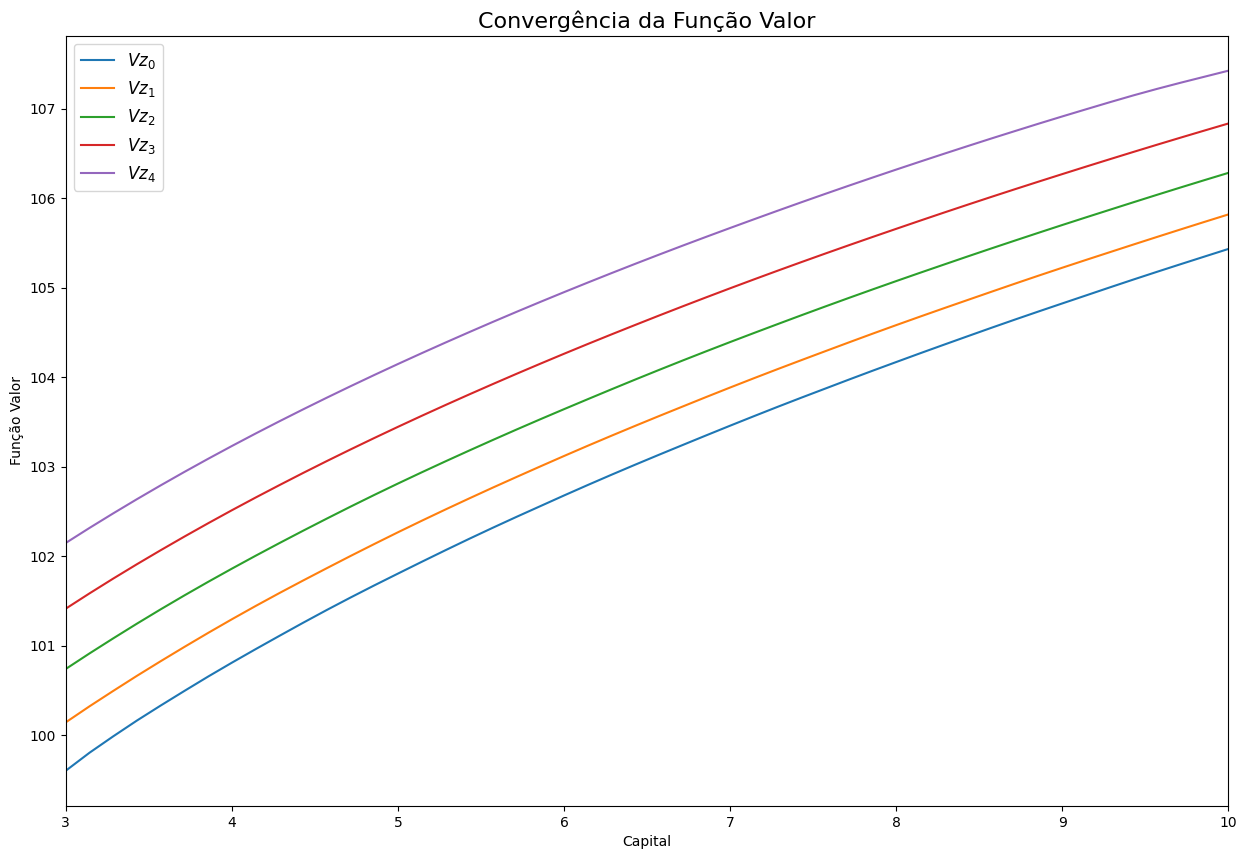

In [ ]:
# Agora vamos plotar a convergência da Função Valor
fig, ax = plt.subplots(figsize = (15, 10))

# Plota as curvas
for i in range(len(V)):
    ax.plot(K, V[i], label = "$Vz_{" + str(i) + '}$')

# Formata o gráfico
ax.legend(fontsize = 12) # Box de legenda
ax.set_title("Convergência da Função Valor", fontsize = 16) # Título do gráfico
ax.set_xlim(K[0], K[-1])
ax.set_xlabel("Capital")
ax.set_ylabel("Função Valor")
plt.show()

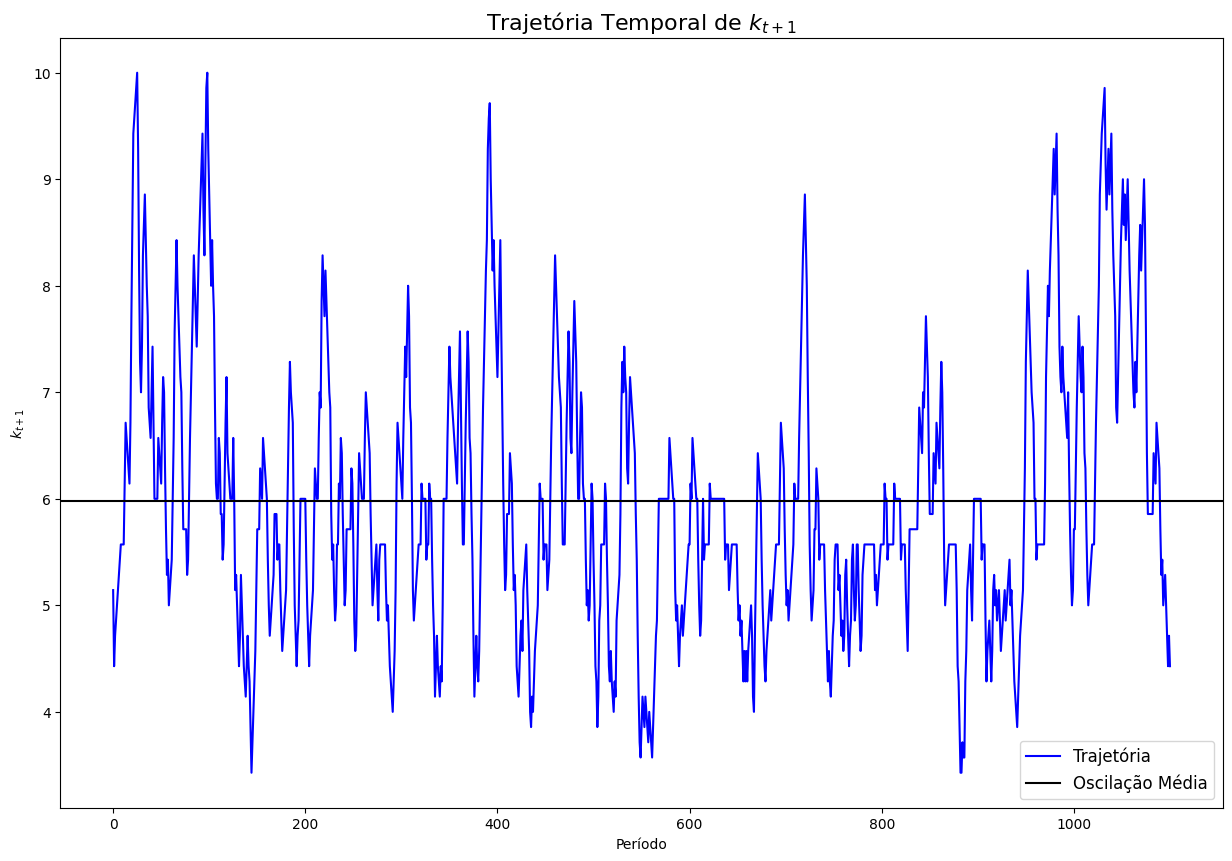

In [ ]:
# Cria o gráfico
fig, ax = plt.subplots(figsize = (15, 10))

# Plota as curvas
ax.plot(range(tamanho_trajetoria + 1), trajetoria_capital, label = "Trajetória", color = "blue")
ax.axhline(y = np.mean(trajetoria_capital), color = "black", label = "Oscilação Média")

# Coloca título e legenda
ax.legend(fontsize = 12) # Box de legenda
ax.set_title("Trajetória Temporal de $k_{t+1}$", fontsize = 16) # Título do gráfico

# Nomeia os eixos
ax.set_xlabel("Período") # Nomeia o eixo x
ax.set_ylabel("$k_{t+1}$") # Nomeia o eixo y
plt.show()

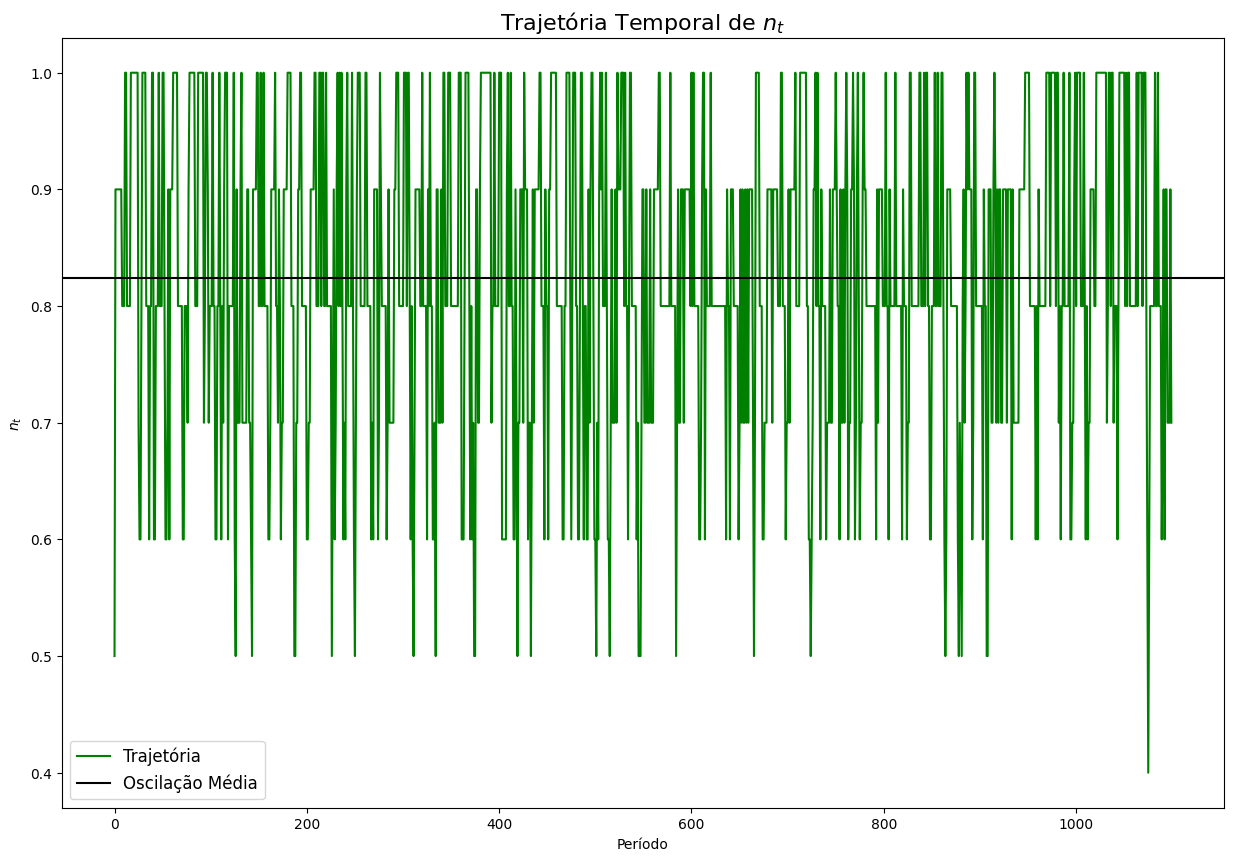

In [ ]:
# Cria o gráfico
fig, ax = plt.subplots(figsize = (15, 10))

# Plota as curvas
ax.plot(range(tamanho_trajetoria), trabalho, label = "Trajetória", color = "green")
ax.axhline(y = np.mean(trabalho), color = "black", label = "Oscilação Média")

# Coloca título e legenda
ax.legend(fontsize = 12) # Box de legenda
ax.set_title("Trajetória Temporal de $n_t$", fontsize = 16) # Título do gráfico

# Nomeia os eixos
ax.set_xlabel("Período") # Nomeia o eixo x
ax.set_ylabel("$n_t$") # Nomeia o eixo y
plt.show()

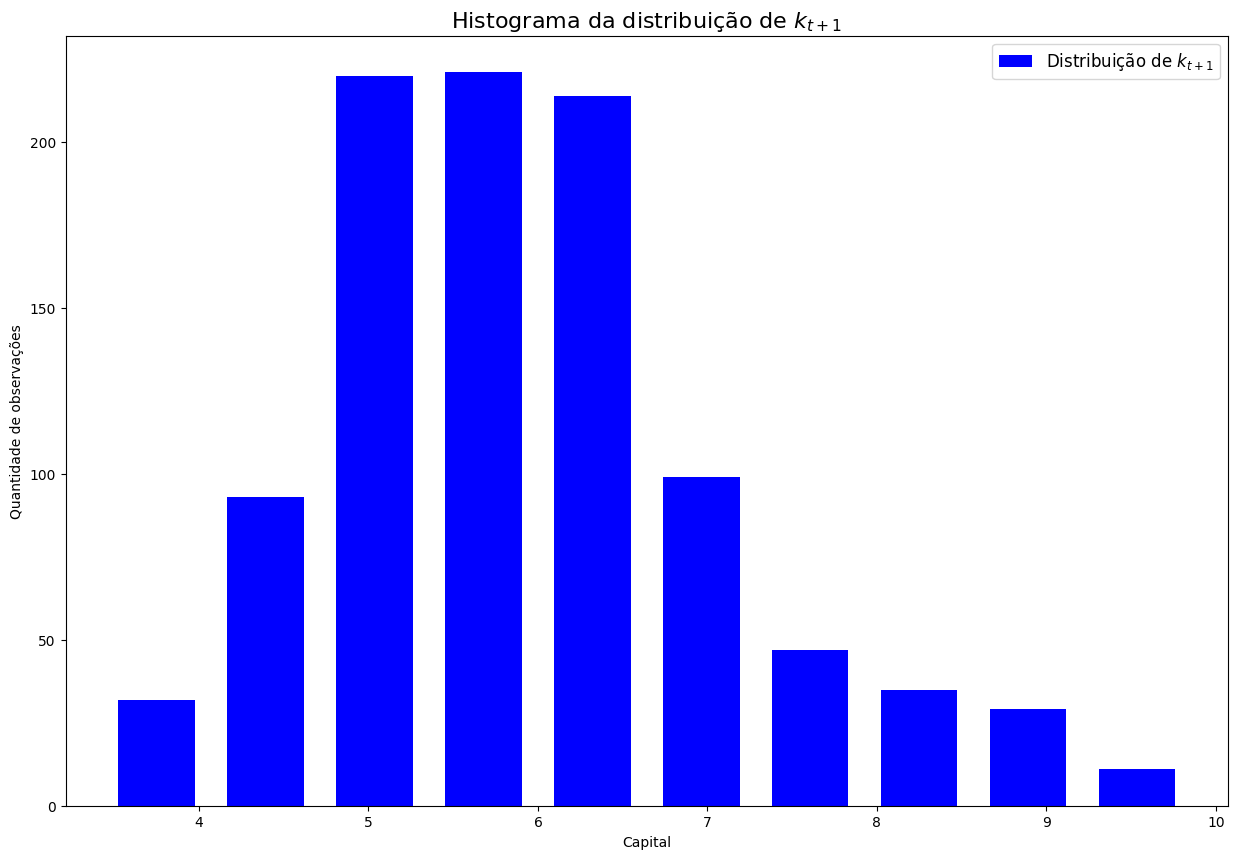

In [ ]:
# Vamos excluir os 100 primeiros valores e fazer o histograma
histograma = trajetoria_capital[100:]

# Cria o gráfico das funções e formata
fig, ax = plt.subplots(figsize = (15, 10))

plt.hist(histograma, bins = 10, label = "Distribuição de $k_{t+1}$", rwidth = 0.7, color = "blue")

# Coloca título e legenda
ax.legend(fontsize = 12) # Box de legenda
ax.set_title("Histograma da distribuição de $k_{t+1}$", fontsize = 16) # Título do gráfico

# Nomeia os eixos
ax.set_xlabel("Capital") # Nomeia o eixo x
ax.set_ylabel("Quantidade de observações") # Nomeia o eixo y
plt.show()

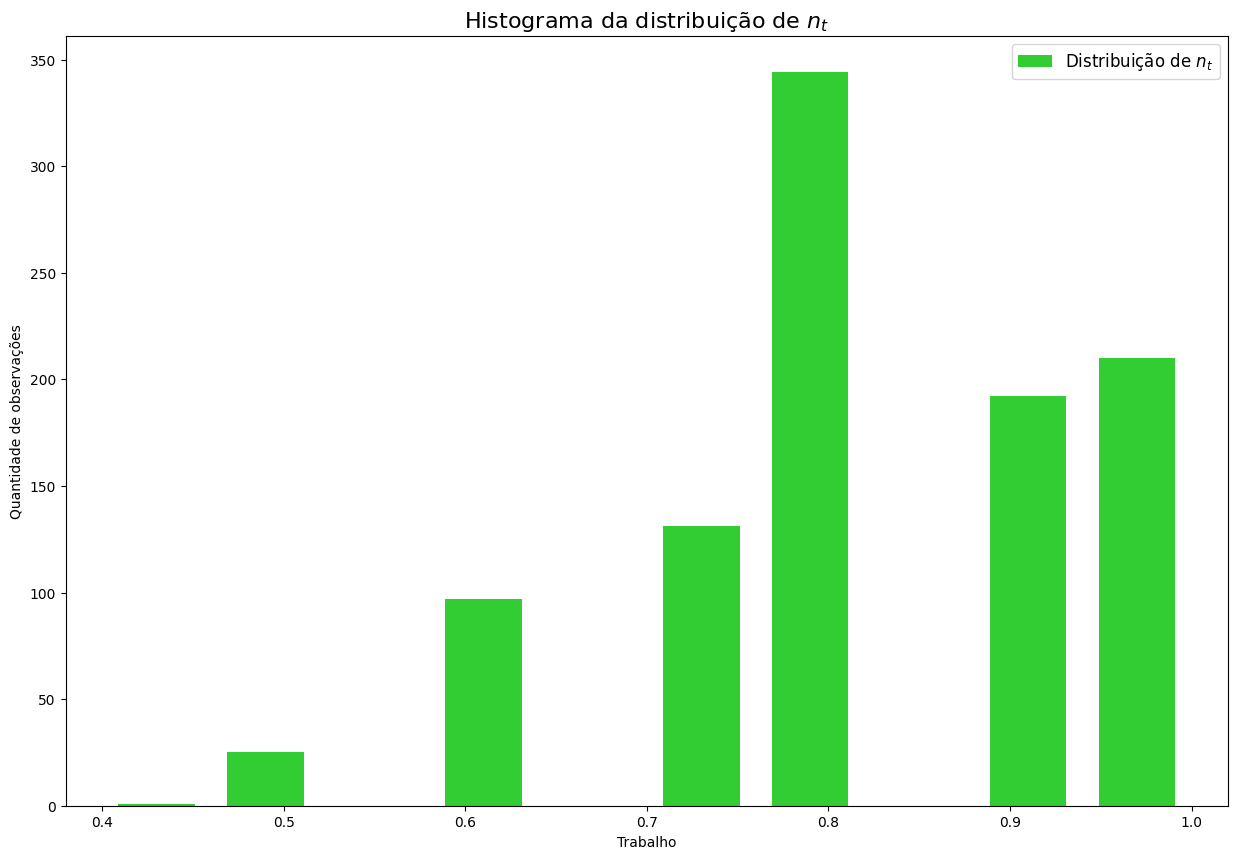

In [ ]:
# Vamos excluir os 100 primeiros valores e fazer o histograma
histograma2 = trabalho[100:]

# Cria o gráfico das funções e formata
fig, ax = plt.subplots(figsize = (15, 10))

plt.hist(histograma2, bins = 10, label = "Distribuição de $n_t$", rwidth = 0.7, color = "limegreen")

# Coloca título e legenda
ax.legend(fontsize = 12) # Box de legenda
ax.set_title("Histograma da distribuição de $n_t$", fontsize = 16) # Título do gráfico

# Nomeia os eixos
ax.set_xlabel("Trabalho") # Nomeia o eixo x
ax.set_ylabel("Quantidade de observações") # Nomeia o eixo y
plt.show()

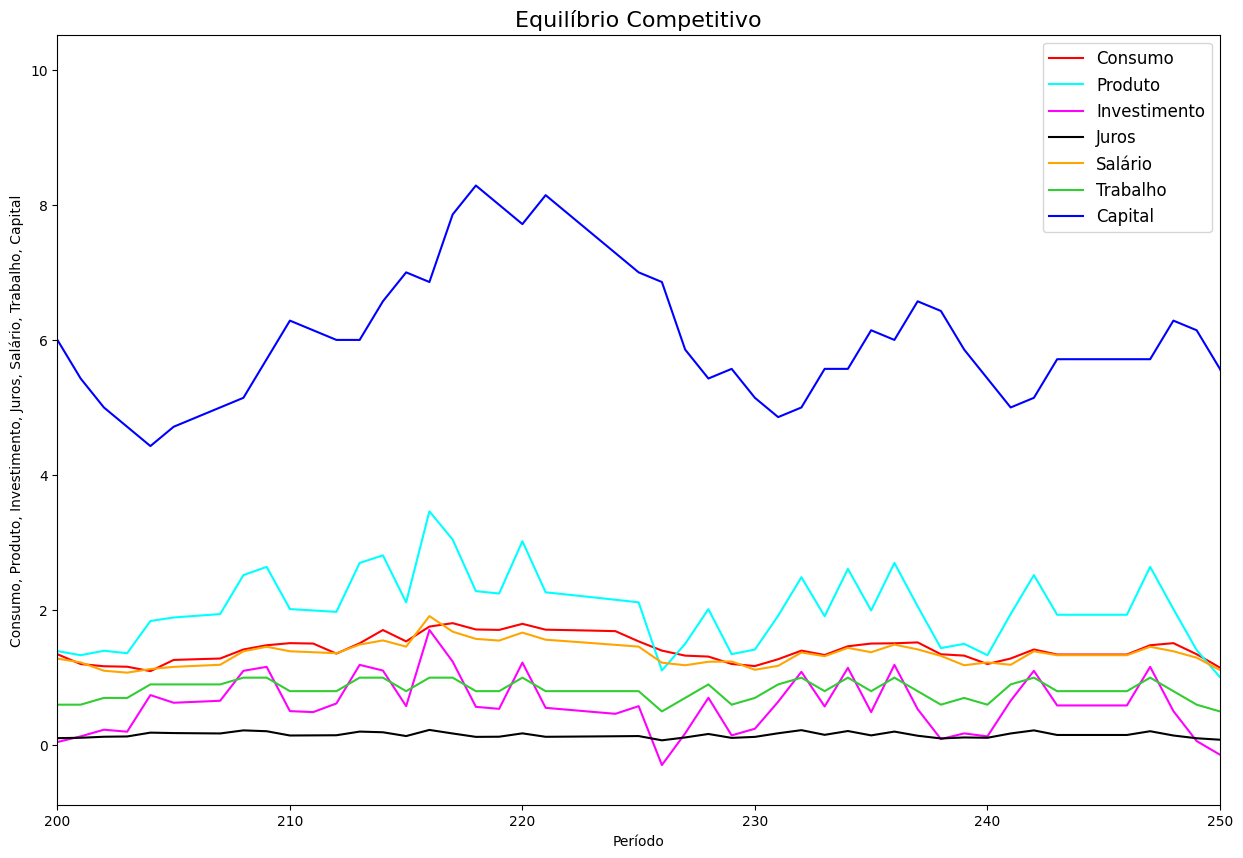

In [ ]:
# Plota o Equilíbrio Competitivo
fig, ax = plt.subplots(figsize = (15, 10))

ax.plot(range(tamanho_trajetoria), consumo, label = "Consumo", color = "red")
ax.plot(range(tamanho_trajetoria), produto, label = "Produto", color = "aqua")
ax.plot(range(tamanho_trajetoria), investimento, label = "Investimento", color = "magenta")
ax.plot(range(tamanho_trajetoria), juros, label = "Juros", color = "black")
ax.plot(range(tamanho_trajetoria), salario, label = "Salário", color = "orange")
ax.plot(range(tamanho_trajetoria), trabalho, label = "Trabalho", color = "limegreen")
ax.plot(range(tamanho_trajetoria), trajetoria_capital[0:1100], label = "Capital", color = "blue")

# Formata o gráfico
ax.legend(fontsize = 12) # Box de legenda
ax.set_title("Equilíbrio Competitivo", fontsize = 16) # Título do gráfico
ax.set_xlim(200, 250)
ax.set_xlabel("Período")
ax.set_ylabel("Consumo, Produto, Investimento, Juros, Salário, Trabalho, Capital")
plt.show()

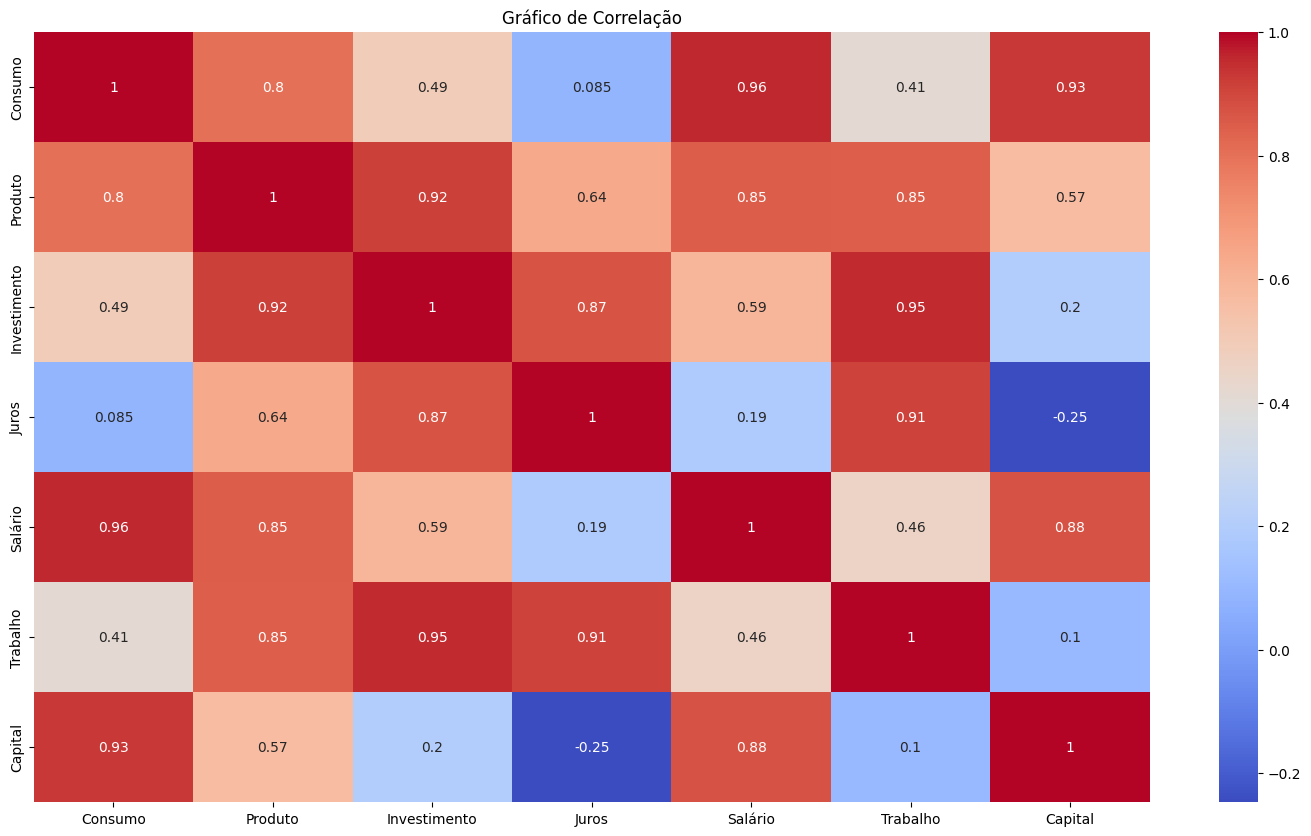

In [ ]:
# Concatena as listas de dados em uma matriz
matriz_correlacao = {'Consumo': consumo, 'Produto': produto, 'Investimento': investimento, 'Juros': juros,
                     'Salário': salario, 'Trabalho': trabalho, 'Capital': trajetoria_capital[0:1100]}
correlacao = pd.DataFrame(matriz_correlacao).corr()

# Calcula a matriz de correlação
fig, ax = plt.subplots(figsize = (18, 10))

# Plota o heatmap
sns.heatmap(correlacao, annot=True, cmap="coolwarm")
plt.title('Gráfico de Correlação')
plt.show()

In [ ]:
end = time.time()

print("Tempo de Execução:", int(end - start), "segundos.")

Tempo de Execução: 262 segundos.
